In [4]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from DeepAR import DeepAR
from dataset import MyLoader, conditioning_range, prediction_range
%matplotlib inline 

In [8]:
model = DeepAR()
model = torch.load('model/model.pth')
loader = MyLoader('test')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
y = []
y_pre = []
for z1, z2, xc in loader:
    z1 = z1.permute(2, 1, 0).to(device)
    z2 = z2.permute(2, 1, 0).to(device)
    xc = xc.repeat(z1.shape[0], 1, 1).to(device)
    outputs, _, _ = model(z1, xc, device)
    y.extend(z2.reshape(-1).detach().cpu().numpy())
    y_pre.extend(outputs.reshape(-1).detach().cpu().numpy())

np.sum(np.abs(np.array(y)-np.array(y_pre))) / np.sum(np.abs(y)), np.sqrt(mean_squared_error(y, y_pre)) / np.mean(np.abs(y))

(0.12426269, 0.9723088)

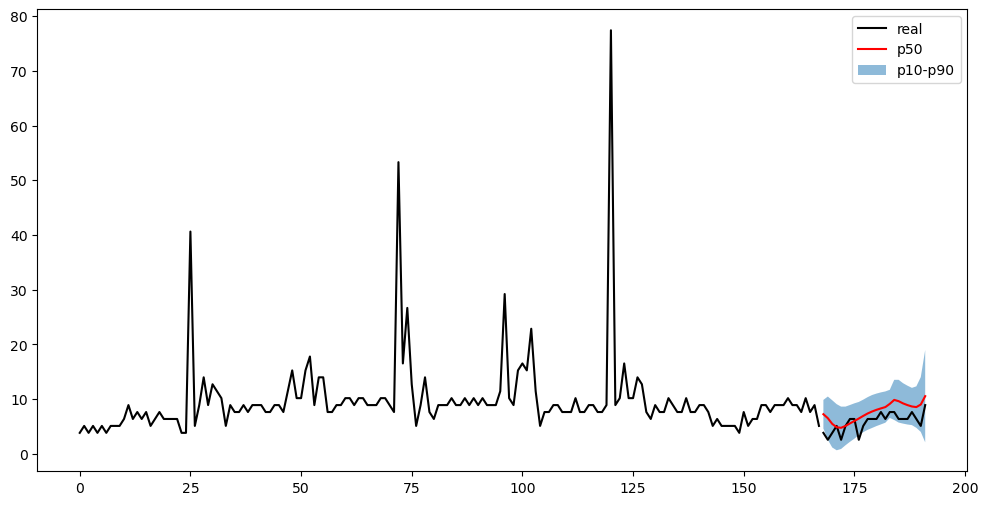

In [13]:
model = torch.load('model/model.pth')
loader = MyLoader('train')
device = 'cuda' if torch.cuda.is_available() else 'cpu'


for z1, z2, xc in loader:
    z1 = z1.permute(2, 1, 0).to(device)
    z2 = z2.permute(2, 1, 0).to(device)
    xc = xc.repeat(z1.shape[0], 1, 1).to(device)
    _, mu, sigma = model(z1, xc, device)

    fig = plt.figure(figsize=(12, 6))
    gaussian = torch.distributions.normal.Normal(mu[0, :, :], sigma[0, :, :])
    p50 = gaussian.icdf(torch.Tensor(
        [0.5]).to(device)).reshape(-1).detach().cpu().numpy()
    p90 = gaussian.icdf(torch.Tensor(
        [0.9]).to(device)).reshape(-1).detach().cpu().numpy()
    p10 = gaussian.icdf(torch.Tensor(
        [0.1]).to(device)).reshape(-1).detach().cpu().numpy()

    plt.plot(range(conditioning_range, prediction_range + conditioning_range),
             z2[0, :, :].reshape(-1).detach().cpu().numpy(),
             color='black')
    plt.plot(range(conditioning_range, prediction_range + conditioning_range),
             p50,
             color='red')
    plt.fill_between(range(conditioning_range,
                           prediction_range + conditioning_range),
                     p10,
                     p90,
                     alpha=0.5)
    plt.legend(['real', 'p50', 'p10-p90'])
    plt.plot(range(conditioning_range),
             z1[0, :, :].reshape(-1).detach().cpu().numpy(),
             color='black')

    break
